In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query = session.query(Measurement.date, func.sum(Measurement.prcp)). \
group_by(Measurement.date).order_by(Measurement.id.desc()).limit(365).all()

query

[('2017-08-23', 0.53),
 ('2017-08-22', 0.5),
 ('2017-08-21', 0.5800000000000001),
 ('2017-08-20', 0.01),
 ('2017-08-19', 0.09),
 ('2017-08-18', 0.06),
 ('2017-08-17', 0.19),
 ('2017-08-16', 0.61),
 ('2017-08-15', 0.8200000000000001),
 ('2017-08-14', 0.31),
 ('2017-08-13', 0.0),
 ('2017-08-12', 0.14),
 ('2017-08-11', 0.0),
 ('2017-08-10', 0.07),
 ('2017-08-09', 0.15),
 ('2017-08-08', 0.44000000000000006),
 ('2017-08-07', 0.05),
 ('2017-08-06', 0.0),
 ('2017-08-05', 0.06),
 ('2017-08-03', 0.06999999999999999),
 ('2017-08-02', 0.3),
 ('2017-08-01', 0.13999999999999999),
 ('2017-07-31', 0.0),
 ('2017-07-30', 0.3),
 ('2017-07-29', 0.61),
 ('2017-07-28', 0.77),
 ('2017-07-27', 0.01),
 ('2017-07-26', 0.5),
 ('2017-07-25', 0.61),
 ('2017-07-24', 3.2699999999999996),
 ('2017-07-23', 1.1300000000000001),
 ('2017-07-22', 4.42),
 ('2017-07-21', 0.13),
 ('2017-07-20', 1.24),
 ('2017-07-19', 0.41000000000000003),
 ('2017-07-18', 2.53),
 ('2017-07-17', 0.91),
 ('2017-07-16', 0.81),
 ('2017-07-15', 0.

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.DataFrame(query, columns=['Date', 'Precipitation'])
data = data.sort_index(ascending=False)
data = data.reset_index()
data = data.drop("index", 1)
data = data.set_index('Date')
data.head()

,Precipitation
Date,
2016-08-07,3.34
2016-08-08,0.66
2016-08-09,0.59
2016-08-10,0.00
2016-08-11,0.09


<IPython.core.display.Javascript object>


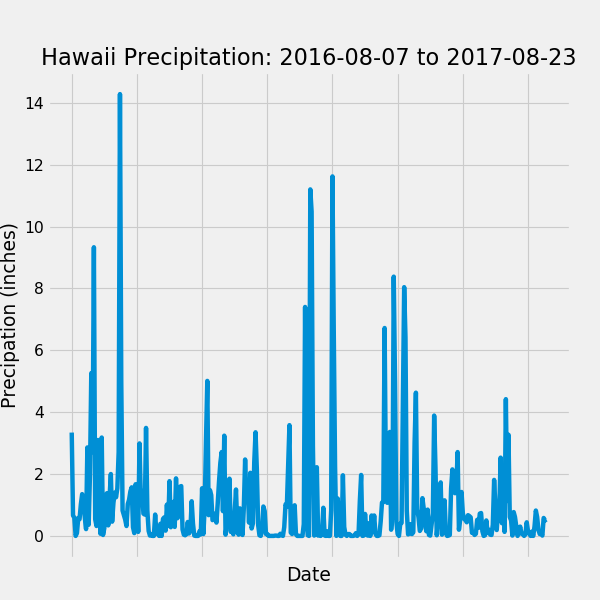

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
data.plot(figsize = (7.5, 7.5), rot = 45, use_index = True, legend=False)
# plt.tight_layout()
plt.ylabel('Precipation (inches)')
plt.xlabel('Date')
plt.title("Hawaii Precipitation: %s to %s" % (data.index.min(),data.index.max()))
plt.savefig("Output/BP_PrecipitationData")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_summary = data.describe()
data_summary

,Precipitation
count,365.000000
mean,1.026795
std,1.794630
min,0.000000
25%,0.060000
50%,0.440000
75%,1.150000
max,14.280000


In [14]:
# How many stations are available in this dataset?
StationCount = session.query(Station.id).count()
print(f'There are {StationCount} stations.')

There are 9 stations.


In [15]:
# What are the most active stations?
# List the stations and the counts in descending order.
ActiveStations = session.query(Measurement.station,func.count(Measurement.station)). \
                 group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
        
ActiveStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
MostActiveStationId = "USC00519281"

Active_TempObs = session.query(Measurement.date, Measurement.tobs).order_by(Measurement.id.desc()). \
    filter(Measurement.station == MostActiveStationId).limit(365).all()
    
Active_TempObs

[('2017-08-18', 79.0),
 ('2017-08-17', 76.0),
 ('2017-08-16', 76.0),
 ('2017-08-15', 77.0),
 ('2017-08-14', 77.0),
 ('2017-08-13', 77.0),
 ('2017-08-06', 83.0),
 ('2017-08-05', 82.0),
 ('2017-08-04', 77.0),
 ('2017-07-31', 76.0),
 ('2017-07-30', 81.0),
 ('2017-07-29', 82.0),
 ('2017-07-28', 81.0),
 ('2017-07-27', 76.0),
 ('2017-07-26', 75.0),
 ('2017-07-25', 77.0),
 ('2017-07-24', 75.0),
 ('2017-07-23', 82.0),
 ('2017-07-22', 77.0),
 ('2017-07-21', 77.0),
 ('2017-07-20', 77.0),
 ('2017-07-19', 76.0),
 ('2017-07-18', 76.0),
 ('2017-07-17', 76.0),
 ('2017-07-16', 80.0),
 ('2017-07-15', 80.0),
 ('2017-07-14', 76.0),
 ('2017-07-13', 74.0),
 ('2017-07-12', 74.0),
 ('2017-07-11', 72.0),
 ('2017-07-10', 69.0),
 ('2017-07-09', 78.0),
 ('2017-07-08', 78.0),
 ('2017-07-07', 75.0),
 ('2017-07-06', 74.0),
 ('2017-07-05', 77.0),
 ('2017-07-04', 78.0),
 ('2017-07-03', 76.0),
 ('2017-07-02', 81.0),
 ('2017-07-01', 79.0),
 ('2017-06-30', 76.0),
 ('2017-06-29', 76.0),
 ('2017-06-28', 77.0),
 ('2017-06-

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
TempObs = pd.DataFrame(Active_TempObs, columns=["Date", "Temperature Observations"])
TempObs.head()

,Date,Temperature Observations
0,2017-08-18,79.0
1,2017-08-17,76.0
2,2017-08-16,76.0
3,2017-08-15,77.0
4,2017-08-14,77.0


<IPython.core.display.Javascript object>


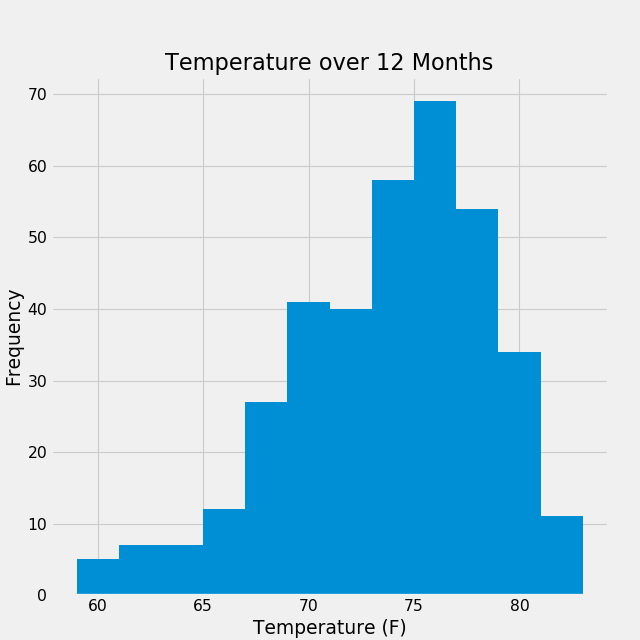

In [18]:
plt.figure(figsize = (8, 8))
plt.hist(TempObs["Temperature Observations"], bins=12)
plt.grid
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.title("Temperature over 12 Months")
plt.savefig("Output/BP_TemperatureHistogram")
plt.show()

In [22]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
class Temperature():
    def __init__(self, min, avg, max):
        self.min = min
        self.avg = avg
        self.max = max
        

def calc_temps(start_date, end_date):
    min = session.query(func.min(Measurement.tobs)).filter(Measurement.date.between(start_date, end_date)).scalar()
    print(f'Minimum temperature: {min}')
    avg = session.query(func.round(func.avg(Measurement.tobs))).filter(Measurement.date.between(start_date, end_date)).scalar()
    print(f'Average temperature: {avg}')
    max = session.query(func.max(Measurement.tobs)).filter(Measurement.date.between(start_date, end_date)).scalar()
    print(f'Maximum temperature: {max}')
    
    Results = [{"Minimum":min},{"Maximum":max},{"Average":avg}]
    Results = Temperature(min, avg, max)
    return Results 



In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
result = calc_temps('2012-02-28', '2012-03-05')
result.min, result.avg, result.max

Minimum temperature: 62.0
Average temperature: 70.0
Maximum temperature: 74.0


(62.0, 70.0, 74.0)

<IPython.core.display.Javascript object>


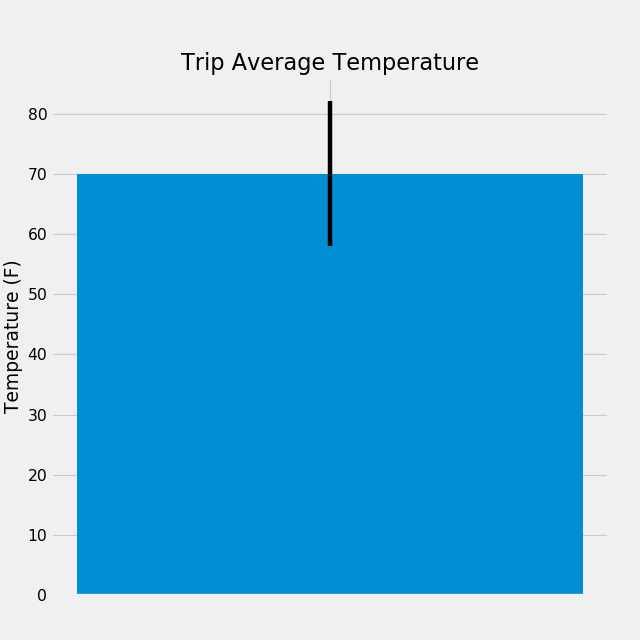

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(8,8))
plt.title("Trip Average Temperature")
plt.ylabel("Temperature (F)")
plt.bar(1, result.avg, yerr = (result.max - result.min), tick_label = "")

# Save an image of the chart and print to screen
plt.savefig("Output/TemperatureBarGraph")
plt.show()

In [33]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, \
                        func.sum(Measurement.prcp)).filter(Measurement.date.between('2011-07-01','2011-07-15')). \
                        group_by(Measurement.station).all()
rainfall

[('USC00511918',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  0.6300000000000003),
 ('USC00513117',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  4.409999999999996),
 ('USC00514830',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  5.7599999999999945),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  17.18999999999999),
 ('USC00517948', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 0.0),
 ('USC00518838',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  7.110000000000001),
 ('USC00519281',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  7.739999999999989),
 ('USC00519397', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 2.7),
 ('USC00519523',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  4.049999999999997)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
